<a href="https://colab.research.google.com/github/jglombitza/tutorial_nn_airshowers/blob/main/fully_connected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air-shower reconstruction using a fully-connected network
## Cosmic-ray observatory

- arrival time `T`: arrival time of the first particles
- signal `S`: integrated signal


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

layers = keras.layers

print("keras", keras.__version__)
print("tf", tf.__version__)


keras 2.10.0
tf 2.10.0


In [2]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=19gOSVQ0mhdjMkm5i2u5NsGrWNBdlhR4F"
output = 'airshowers_mnist.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=False)

f = np.load(output)

### Input 1: Arrival times



In [3]:
# time map
T = f['time']
T -= np.nanmean(T)
T /= np.nanstd(T)
T[np.isnan(T)] = 0

print(T.shape)

(100000, 14, 14)


#### Plot four example maps


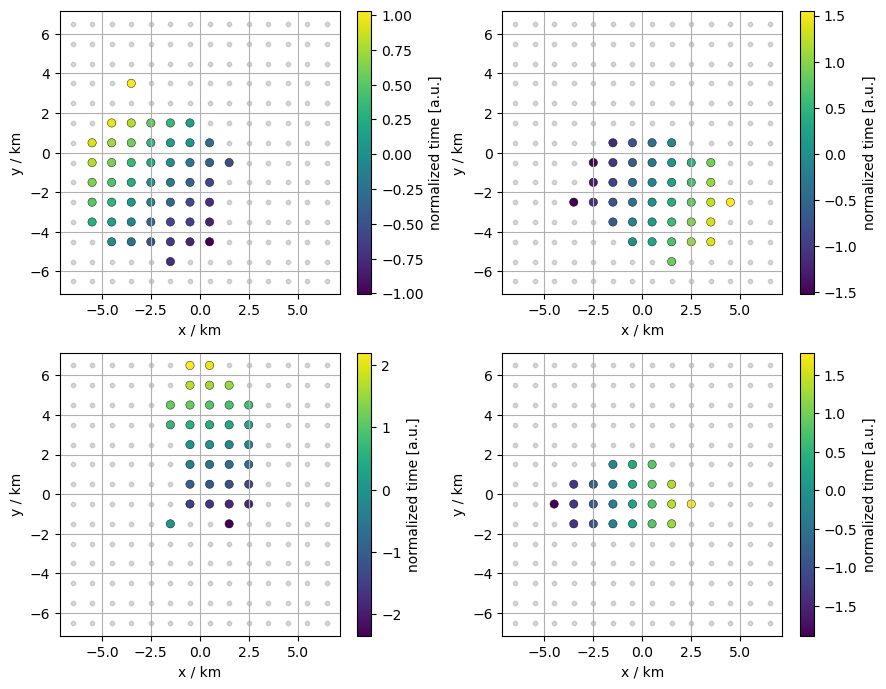

In [4]:
nsamples=len(T)
random_samples = np.random.choice(nsamples, 4)

def rectangular_array(n=14):
    n0 = (n - 1) / 2
    return (np.mgrid[0:n, 0:n].astype(float) - n0)

plt.figure(figsize=(9,7))

for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=T[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 50 * footprint[mask]
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.3, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], 
                          cmap="viridis", alpha=1, label="loud",
                          edgecolors="k", linewidths=0.3)
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized time [a.u.]')
    plt.xlabel("x / km")
    plt.ylabel("y / km")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Input 2: Measured signals


In [5]:
# signal map
S = f['signal']
S = np.log10(1 + S)
S -= np.nanmin(S)
S /= np.nanmax(S)
S[np.isnan(S)] = 0

print(S.shape)

(100000, 14, 14)


#### Plot four example events

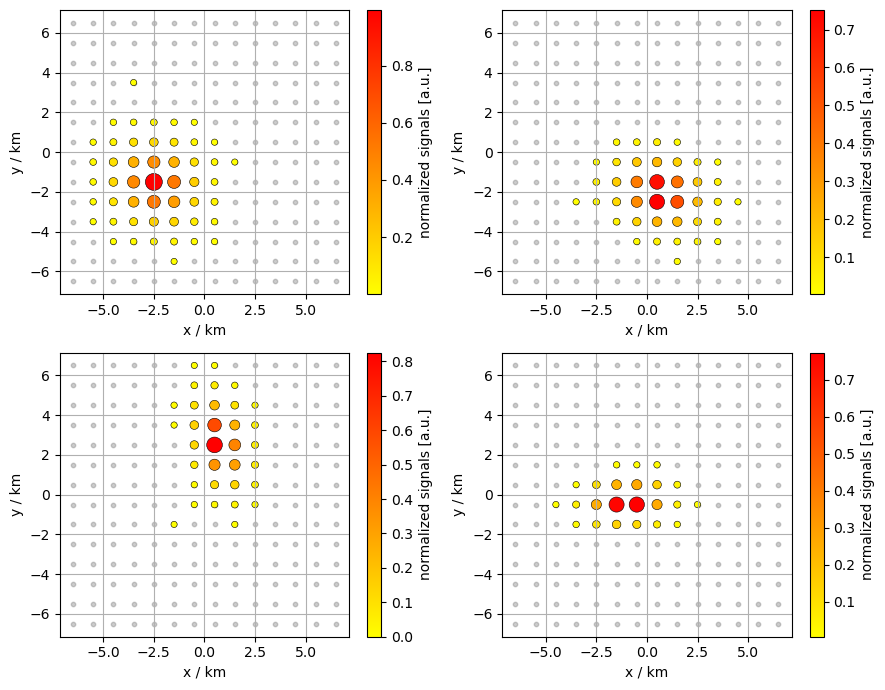

In [6]:
plt.figure(figsize=(9,7))

for i,j in enumerate(random_samples):
    plt.subplot(2,2,i+1)
    footprint=S[j,...]
    xd, yd = rectangular_array()
    mask = footprint != 0
    mask[5, 5] = True
    marker_size = 130 * footprint[mask] + 20
    plot = plt.scatter(xd, yd, c='grey', s=10, alpha=0.4, label="silent")
    circles = plt.scatter(xd[mask], yd[mask], c=footprint[mask], s=marker_size,
                          cmap="autumn_r", alpha=1, label="loud",
                          edgecolors="k", linewidths=0.4)
    cbar = plt.colorbar(circles)
    cbar.set_label('normalized signals [a.u.]')
    plt.xlabel("x / km")
    plt.ylabel("y / km")
    plt.grid(True)

plt.tight_layout()
plt.show()

### Labels


In [7]:
axis = f['showeraxis']

In [8]:
core = f['showercore'][:, 0:2]
core /= 750

In [9]:
# energy - log10(E/eV) in range 3 - 100 EeV
energy = f['energy']
print(energy)

[ 4.00461776  5.99159294  7.49367551 ... 10.81657107  5.07542798
 43.32910954]


---
#### Training and test data


In [10]:
X = np.stack([T, S], axis=-1)

In [11]:
X_train, X_test = np.split(X, [-20000])
energy_train, energy_test = np.split(energy, [-20000])

---
## Define Model


In [12]:
model = keras.models.Sequential(name="energy_regression_NN")

model.add(layers.Flatten(input_shape=X_train.shape[1:]))  # this layer re-arranges the 2D image to a vector, leave it as it is
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1))

Metal device set to: Apple M1 Pro


2022-11-29 17:02:30.358623: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-29 17:02:30.359212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
print(model.summary())

Model: "energy_regression_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 20)                7860      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 7,881
Trainable params: 7,881
Non-trainable params: 0
_________________________________________________________________
None


### Compile


In [14]:
def resolution(y_true, y_pred):
    """ Metric to control for standart deviation """
    mean, var = tf.nn.moments((y_true - y_pred), axes=[0])
    return tf.sqrt(var)


def bias(y_true, y_pred):
    """ Metric to control for standart deviation """
    mean, var = tf.nn.moments((y_true - y_pred), axes=[0])
    return mean

In [15]:
model.compile(
    loss='mean_squared_error',
    metrics=[bias, resolution],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3))

---
### Training


In [16]:
fit = model.fit(
    X_train,
    energy_train,
    batch_size=128,
    epochs=20,
    verbose=2,
    validation_split=0.1,
)

Epoch 1/20


2022-11-29 17:02:58.730317: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-29 17:02:58.893801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 - 3s - loss: 696.7924 - bias: 11.3162 - resolution: 21.6399 - val_loss: 342.8044 - val_bias: 1.0579 - val_resolution: 18.3365 - 3s/epoch - 5ms/step
Epoch 2/20


2022-11-29 17:03:01.149849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


563/563 - 2s - loss: 337.2429 - bias: -8.7440e-01 - resolution: 18.1707 - val_loss: 250.7556 - val_bias: -5.1674e-01 - val_resolution: 15.6974 - 2s/epoch - 4ms/step
Epoch 3/20
563/563 - 2s - loss: 238.4637 - bias: -1.2691e+00 - resolution: 15.2638 - val_loss: 156.4997 - val_bias: 0.1963 - val_resolution: 12.4001 - 2s/epoch - 4ms/step
Epoch 4/20
563/563 - 2s - loss: 180.6969 - bias: -6.1333e-01 - resolution: 13.3376 - val_loss: 124.2435 - val_bias: 1.2045 - val_resolution: 10.9812 - 2s/epoch - 4ms/step
Epoch 5/20
563/563 - 2s - loss: 161.7267 - bias: -8.4673e-02 - resolution: 12.6272 - val_loss: 113.1630 - val_bias: 1.5114 - val_resolution: 10.4345 - 2s/epoch - 4ms/step
Epoch 6/20
563/563 - 2s - loss: 154.0661 - bias: 0.1164 - resolution: 12.3155 - val_loss: 108.7289 - val_bias: 1.7113 - val_resolution: 10.1867 - 2s/epoch - 4ms/step
Epoch 7/20
563/563 - 2s - loss: 149.0300 - bias: 0.2253 - resolution: 12.1186 - val_loss: 104.1841 - val_bias: 1.6218 - val_resolution: 9.9804 - 2s/epoch - 

### Plot training curves

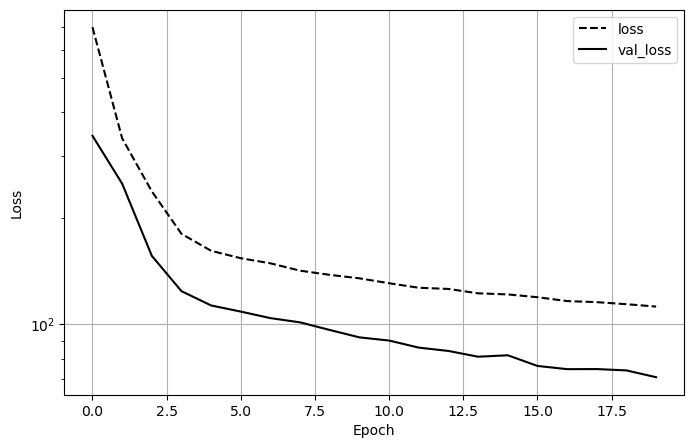

In [17]:
fig, ax = plt.subplots(1, figsize=(8,5))
n = np.arange(len(fit.history['loss']))

ax.plot(n, fit.history['loss'], ls='--', c='k', label='loss')
ax.plot(n, fit.history['val_loss'], label='val_loss', c='k')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.semilogy()
ax.grid()
plt.show()

---
### Performance of the DNN


In [18]:
energy_pred = model.predict(X_test, batch_size=128, verbose=1)[:,0]


100/157 [==================>...........] - ETA: 0s

2022-11-29 17:04:31.796157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 0s 2ms/step


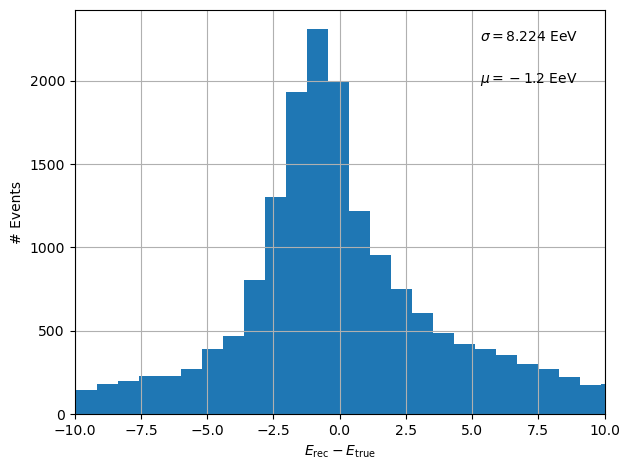

In [19]:
diff = energy_pred - energy_test
resolution = np.std(diff)
plt.figure()
plt.hist(diff, bins=100)
plt.xlabel('$E_\mathrm{rec} - E_\mathrm{true}$')
plt.ylabel('# Events')
plt.text(0.95, 0.95, '$\sigma = %.3f$ EeV' % resolution, ha='right', va='top', transform=plt.gca().transAxes)
plt.text(0.95, 0.85, '$\mu = %.1f$ EeV' % diff.mean(), ha='right', va='top', transform=plt.gca().transAxes)
plt.grid()
plt.xlim(-10, 10)
plt.tight_layout()

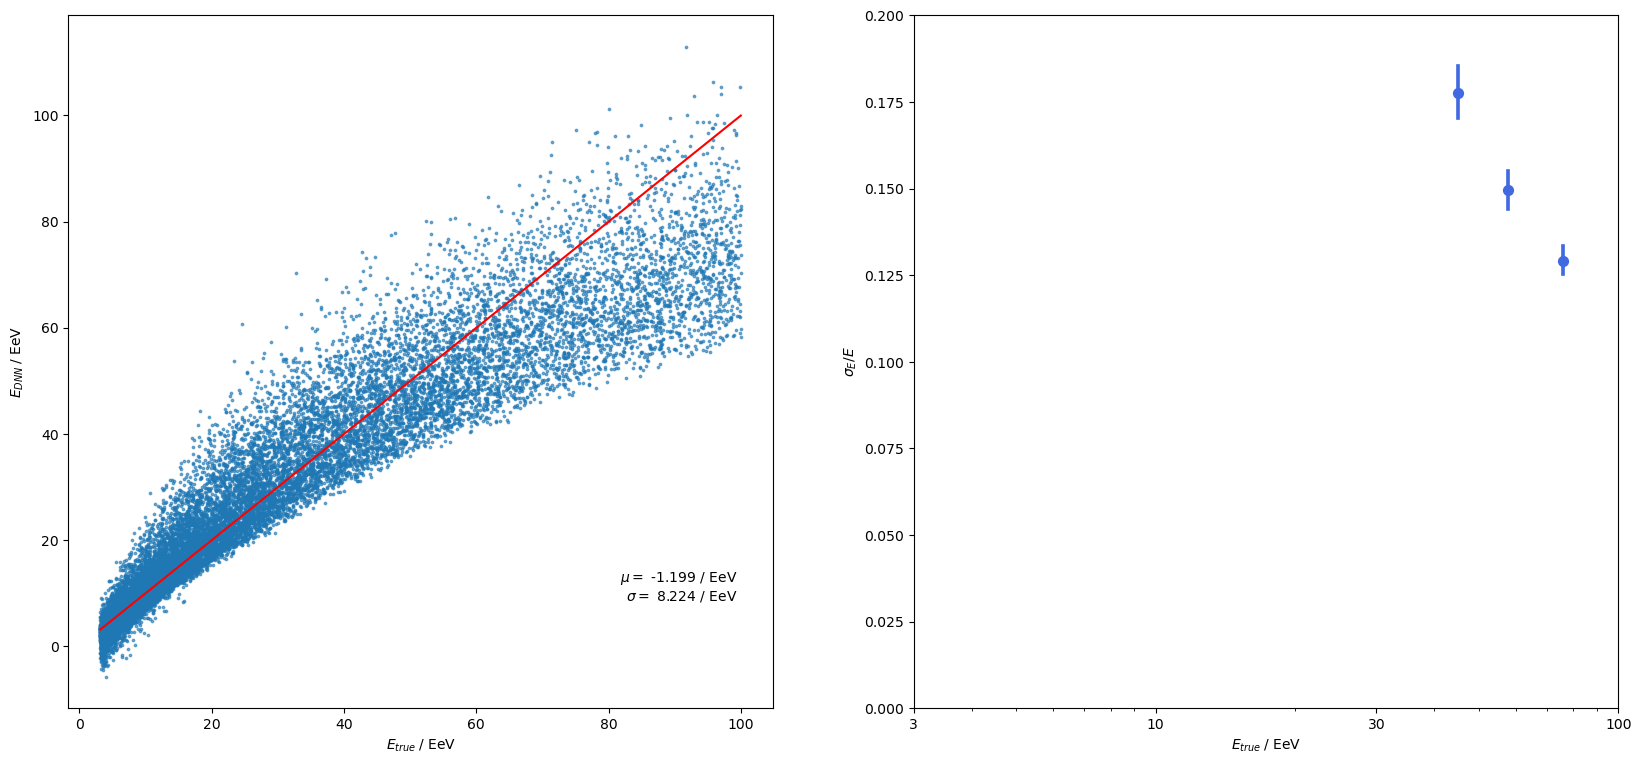

In [20]:
x = [3, 10, 30, 100]
labels = ["3", "10", "30", "100"]

diff = energy_pred - energy_test

# Embedding plot
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
axes[0].scatter(energy_test, energy_pred, s=3, alpha=0.60)
axes[0].set_xlabel(r"$E_{true}\;/\;\mathrm{EeV}$")
axes[0].set_ylabel(r"$E_{DNN}\;/\;\mathrm{EeV}$")

stat_box = r"$\mu = $ %.3f" % np.mean(diff) + " / EeV" + "\n" + "$\sigma = $ %.3f" % np.std(diff) + " / EeV"
axes[0].text(0.95, 0.2, stat_box, verticalalignment="top", horizontalalignment="right",
          transform=axes[0].transAxes, backgroundcolor="w")
axes[0].plot([np.min(energy_test), np.max(energy_test)],
             [np.min(energy_test), np.max(energy_test)], color="red")

sns.regplot(x=energy_test, y=diff / energy_test, x_estimator=np.std, x_bins=12,
            fit_reg=False, color="royalblue", ax=axes[1])
axes[1].tick_params(axis="both", which="major")
axes[1].set(xscale="log")
plt.xticks(x, labels)

axes[1].set_xlabel(r"$E_{true}\;/\;\mathrm{EeV}$")
axes[1].set_ylabel(r"$\sigma_{E}/E$")
axes[1].set_ylim(0, 0.2)
plt.show()